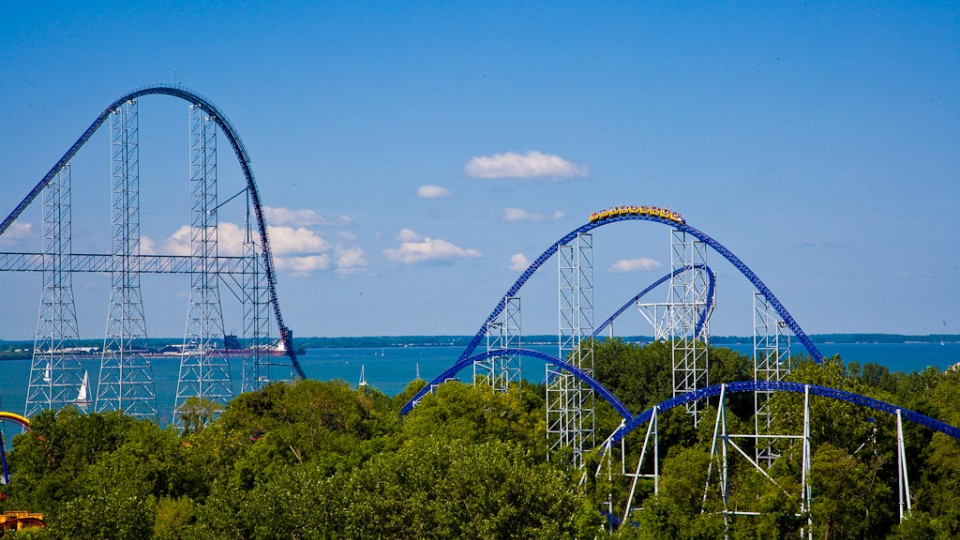

*Image source: Theme Park Tourist*

# Rollercoaster Database: Data Collection

This Kaggle notebook contains the code needed to scrape data from the rollercoaster database website [rcdb.com](rcdb.com) into a CSV file, which will then be automatically uploaded into [this Kaggle dataset](https://www.kaggle.com/datasets/mcpenguin/rollercoasters).

We will utilize the code from [this Chrome For Testing + Selenium tutorial notebook I made](https://www.kaggle.com/code/mcpenguin/tutorial-selenium-chrome-for-testing).

## Some of my other work

### Notebooks

- [Butterfly Image Classification](https://www.kaggle.com/code/mcpenguin/butterfly-classification-efficientnet-87)
- [Palmer Penguin EDA](https://www.kaggle.com/code/mcpenguin/palmer-archipelago-antarctica-penguin-eda)
- [Smoking and Drinking EDA + Classification](https://www.kaggle.com/code/mcpenguin/smoking-drinking-prediction-tfdf-71)
- [World Happiness Data Cleaning + EDA](https://www.kaggle.com/code/mcpenguin/world-happiness-data-cleaning-eda)
- [Precious Metals Stocks: EDA + Forecasting](https://www.kaggle.com/code/mcpenguin/precious-metals-stocks-eda-and-prediction)
- [Red Wine Quality EDA + Prediction](https://www.kaggle.com/code/mcpenguin/red-wine-quality-prediction)
- [Gaia Stellar Classification](https://www.kaggle.com/code/mcpenguin/gaia-stellar-classification-lightgbm-91-acc)

### Datasets

- [Malaysian Condominium Prices Data](https://www.kaggle.com/datasets/mcpenguin/raw-malaysian-housing-prices-data)
- [The Complete Rollercoasters Dataset](https://www.kaggle.com/datasets/mcpenguin/rollercoasters)
- [Malaysian COVID-19 Data](https://www.kaggle.com/datasets/mcpenguin/malaysia-covid19)
- [Super Mario 64 Speedruns](https://www.kaggle.com/datasets/mcpenguin/super-mario-64-speedruns)

# Setting up Chrome and ChromeDriver

## Installing Needed Linux Dependencies

In [1]:
!apt-get update -y
!apt-get install -y \
libglib2.0-0 \
libnss3 \
libdbus-glib-1-2 \
libgconf-2-4 \
libfontconfig1 \
libvulkan1 \
gconf2-common \
libwayland-server0 \
libgbm1 \
udev \
libu2f-udev 
!apt --fix-broken install -y  

'apt-get' is not recognized as an internal or external command,
operable program or batch file.
'apt-get' is not recognized as an internal or external command,
operable program or batch file.
'apt' is not recognized as an internal or external command,
operable program or batch file.


## Installing Google Chrome

In [2]:
!wget -P /tmp https://edgedl.me.gvt1.com/edgedl/chrome/chrome-for-testing/116.0.5845.96/linux64/chrome-linux64.zip
!unzip /tmp/chrome-linux64.zip -d /usr/bin/

'wget' is not recognized as an internal or external command,
operable program or batch file.
unzip:  cannot find either /tmp/chrome-linux64.zip or /tmp/chrome-linux64.zip.zip.


We can check Chrome has successfully installed by checking its version:

In [3]:
!/usr/bin/chrome-linux64/chrome --version

The system cannot find the path specified.


## Installing Chromedriver

In [4]:
!wget -P /tmp https://edgedl.me.gvt1.com/edgedl/chrome/chrome-for-testing/116.0.5845.96/linux64/chromedriver-linux64.zip
!unzip /tmp/chromedriver-linux64.zip -d /usr/bin/

'wget' is not recognized as an internal or external command,
operable program or batch file.


unzip:  cannot find either /tmp/chromedriver-linux64.zip or /tmp/chromedriver-linux64.zip.zip.


Again, to check that the chromedriver has been successfully installed, we can check its version:

In [5]:
!/usr/bin/chromedriver-linux64/chromedriver --version

The system cannot find the path specified.


## Installing Selenium

In [6]:
!apt install -y python3-selenium
!pip install selenium==3.141.0

'apt' is not recognized as an internal or external command,
operable program or batch file.


   ---------------------------------------- 0.0/904.6 kB ? eta -:--:--
   ---------------------------------------- 10.2/904.6 kB ? eta -:--:--
   ---- ----------------------------------- 92.2/904.6 kB 1.7 MB/s eta 0:00:01
   --------------------- ------------------ 481.3/904.6 kB 5.0 MB/s eta 0:00:01
   ---------------------------------------- 904.6/904.6 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: selenium
    Found existing installation: selenium 4.18.1
    Uninstalling selenium-4.18.1:
      Successfully uninstalled selenium-4.18.1


# Import Libraries

In [7]:

import numpy as np
import pandas as pd
import json
import os

import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from tqdm.autonotebook import tqdm

ModuleNotFoundError: No module named 'kaggle_secrets'

# Initialize Selenium WebDriver

In [ ]:
CHROME_BINARY_LOCATION = "/usr/bin/chrome-linux64/chrome"
CHROMEDRIVER_BINARY_LOCATION = "/usr/bin/chromedriver-linux64/chromedriver"

def add_driver_options(options):
    """
    Add configurable options
    """
    chrome_options = Options()
    for opt in options:
        chrome_options.add_argument(opt)
    return chrome_options

def initialize_driver():
    """
    Initialize the web driver
    """
    driver_config = {
        "options": [
            "--headless",
            "--no-sandbox",
            "--start-fullscreen",
            "--allow-insecure-localhost",
            "--disable-dev-shm-usage",
            "user-agent=Chrome/116.0.5845.96"
        ],
    }
    options = add_driver_options(driver_config["options"])
    options.binary_location = CHROME_BINARY_LOCATION
    driver = webdriver.Chrome(
        executable_path=CHROMEDRIVER_BINARY_LOCATION,
        options=options)
    return driver

# Define Helper Functions

In [ ]:
def parse_rollercoaster_page(soup):
    feature = soup.find('div', {"id": "feature"})
    descList = feature.findAll('div')
    
    # location information
    desc = descList[0]
    locationLinks = desc.findAll('a')
    if len(locationLinks) == 3: # amusement park, city, country
        city = locationLinks[1].contents[0]
        region = locationLinks[1].contents[0]
        country = locationLinks[2].contents[0]
    else:
        city = locationLinks[-3].contents[0]
        region = locationLinks[-2].contents[0]
        country = locationLinks[-1].contents[0]
    # make information
    if len(descList) >= 2:
        make = descList[1].find('a').contents[0]
    else:
        make = None
        
    # track information
    trackStats = {}
    trackStatsTable = soup.find('table', {'class': 'stat-tbl'})
    if trackStatsTable is not None:
        trackStatsTag = trackStatsTable.findAll('tr')
        for tr in trackStatsTag:
            key = tr.find('th').contents[0]
            valueTag = tr.findAll('td')[0]

            if key == "Elements": # list of links
                value = list(map(lambda v: v.contents[0], valueTag.findAll('a')))
            elif valueTag.find('span', {'class': 'float'}) is not None: # float value
                if len(valueTag.contents) >= 2: # numerical value has a unit
                    unit = valueTag.contents[1].strip()
                    key = f"{key} ({unit})"
                value = valueTag.find('span', {'class': 'float'}).contents[0]
            else: # default
                if len(valueTag.contents) >= 1:
                    value = valueTag.contents[0]
                else:
                    value = None
            trackStats[key] = value

    return city, region, country, make, trackStats

def parse_rollercoaster_table_row(row):
    # get data from table
    elements = row.findAll('td')
    coasterName = elements[1].find('a').contents[0]
    coasterLink = elements[1].find('a')['href']
    amusementPark = elements[2].find('a').contents[0]
    coasterType = elements[3].find('a').contents[0]
    coasterDesign = elements[4].find('a').contents[0]
    statusTag = elements[5].find('a')
    if statusTag is not None:
        status = statusTag.contents[0]
    else:
        status = "Removed"
    openedTag = elements[6].find('time')
    if openedTag is not None:
        opened = openedTag.contents[0]
    else:
        opened = "unknown"

    # get data from rollercoaster specific link
    driver.get(f"{rcdb_url}{coasterLink}")
    coaster_soup = BeautifulSoup(driver.page_source, 'html')
    city, region, country, make, trackStats = parse_rollercoaster_page(coaster_soup)

    return {
        'Name': coasterName, 
        'Amusement Park': amusementPark, 
        'Type': coasterType, 
        'Design': coasterDesign, 
        'Status': status, 
        'Opened': opened, 
        'City': city, 
        'Region': region, 
        'Country': country, 
        'Make': make,
        **trackStats
    }

# Scrape and Collect Information

In [ ]:
rcdb_url = "https://rcdb.com"

driver = initialize_driver()
driver.get(f"{rcdb_url}/r.htm?ot=2")
soup = BeautifulSoup(driver.page_source, 'html')
numPages = int(soup.find('div', {"id": "rfoot"}).findAll('a')[-2].contents[0])
print(f"Total number of pages to iterate through: {numPages}")

pbar = tqdm(range(numPages))
rollercoasters = []

for pageNum in pbar:
    print(f"Getting information for page {pageNum+1}")
    driver.get(f"{rcdb_url}/r.htm?page={pageNum+1}&ot=2")
    soup = BeautifulSoup(driver.page_source, 'html')
    table = soup.findAll('table')[1].find('tbody')
    rows = table.findAll('tr')
    
    for row in rows:
        rowData = parse_rollercoaster_table_row(row)
        pbar.set_postfix(
            coasterName=rowData['Name'], 
            amusementPark=rowData['Amusement Park'])
        rollercoasters.append(rowData)
        
    # every page, save the information to a dataframe
    df = pd.DataFrame.from_records(rollercoasters)
    df.to_csv("data.csv", index=False)

Total number of pages to iterate through: 496


  0%|          | 0/496 [00:00<?, ?it/s]

Getting information for page 1
Getting information for page 2
Getting information for page 3
Getting information for page 4
Getting information for page 5
Getting information for page 6
Getting information for page 7
Getting information for page 8
Getting information for page 9
Getting information for page 10
Getting information for page 11
Getting information for page 12
Getting information for page 13
Getting information for page 14
Getting information for page 15
Getting information for page 16
Getting information for page 17
Getting information for page 18
Getting information for page 19
Getting information for page 20
Getting information for page 21
Getting information for page 22
Getting information for page 23
Getting information for page 24
Getting information for page 25
Getting information for page 26
Getting information for page 27
Getting information for page 28
Getting information for page 29
Getting information for page 30
Getting information for page 31
Getting informati

In [ ]:
driver.quit()

# Information About Data

In [ ]:
df.head()

,Name,Amusement Park,Type,Design,Status,Opened,City,Region,Country,Make,...,Duration,G-Force,Vertical Angle (°),Uphill Length (ft),Downhill Length (ft),Δ Elevation (ft),Airtime Points,Crossings,Bank Angle (°),Drop
0,€uro-Coaster,Wiener Prater,Steel,Suspended,Removed,5/29/2020,Vienna,Vienna,Austria,Reverchon,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,€uro Coaster,Funland Theme Park,Steel,Sit Down,Removed,2021,Somerset,England,United Kingdom,SBF Visa Group,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1066,Festyland,Steel,Sit Down,Operating,3/27/2005,Bretteville-Sur-Odon,Normandy,France,Soquet,...,1:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10 Inversion Roller Coaster,Chimelong Paradise,Steel,Sit Down,Operating,2/2006,Guangzhou,Guangdong,China,Intamin Amusement Rides,...,1:32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1970 Galaxy Rip Tide Coaster,Swampy Jack's Wongo Adventure,Steel,Sit Down,Relocated,6/27/2014,Panama City Beach,Florida,United States,S.D.C.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11889 entries, 0 to 11888
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Name                  11889 non-null  object 
 1   Amusement Park        11889 non-null  object 
 2   Type                  11889 non-null  object 
 3   Design                11889 non-null  object 
 4   Status                11889 non-null  object 
 5   Opened                11889 non-null  object 
 6   City                  11889 non-null  object 
 7   Region                11889 non-null  object 
 8   Country               11889 non-null  object 
 9   Make                  7777 non-null   object 
 10  Length (ft)           3618 non-null   object 
 11  Height (ft)           3068 non-null   object 
 12  Speed (mph)           2409 non-null   object 
 13  Inversions            11870 non-null  object 
 14  Elements              5555 non-null   object 
 15  Drop (ft)          

# Process Kaggle API Key

In [ ]:
if os.path.exists('/root/.kaggle/'):
    pass
else:
    os.mkdir('/root/.kaggle/')
kaggle_API_key = UserSecretsClient().get_secret("KAGGLE_API_KEY")

with open('/root/.kaggle/kaggle.json', 'w') as fid:
    fid.writelines(f'{{"username":"mcpenguin","key":"{kaggle_API_key}"}}')

!chmod 600 /root/.kaggle/kaggle.json

# Upload Data to Kaggle Dataset

In [ ]:
metadata = {
    "id": "mcpenguin/rollercoasters",
    "title": "New Update"
}

In [ ]:
with open('/kaggle/working/dataset-metadata.json', 'w') as json_fid:
    json_fid.write(json.dumps(metadata))

In [ ]:
!kaggle datasets download mcpenguin/rollercoasters

100%|█████████████████████████████████████████| 519k/519k [00:00<00:00, 940kB/s]
100%|█████████████████████████████████████████| 519k/519k [00:00<00:00, 939kB/s]


In [ ]:
os.remove("/kaggle/working/rollercoasters.zip")

In [ ]:
!kaggle datasets version -p /kaggle/working -m "Updated data"

Starting upload for file __notebook__.ipynb
100%|█████████████████████████████████████████| 378k/378k [00:01<00:00, 245kB/s]
Upload successful: __notebook__.ipynb (378KB)
Starting upload for file data.csv
100%|███████████████████████████████████████| 1.58M/1.58M [00:03<00:00, 498kB/s]
Upload successful: data.csv (2MB)
Dataset version is being created. Please check progress at https://www.kaggle.com/mcpenguin/rollercoasters
